In [1]:
import numpy as np
import pyprop8 as pp
from pyprop8.utils import rtf2xyz, make_moment_tensor,stf_trapezoidal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d


In [90]:
#                                   Layer
#                                thickness Vp    Vs  Density
#                                    km   km/s  km/s  g/cm^3
model = pp.LayeredStructureModel([[ 3.00, 1.80, 0.00, 1.02],
                                  [ 2.00, 4.50, 2.40, 2.57],
                                  [ 5.00, 5.80, 3.30, 2.63],
                                  [20.00, 6.50, 3.65, 2.85],
                                  [np.inf,8.00, 4.56, 3.34]])
model = pp.LayeredStructureModel([[ np.inf, 4.50, 2.40, 2.57]])
print(model)

------------------------------------------------------- z = 0.00 km
  vp = 4.50 km/s   vs = 2.40 km/s   rho = 2.57 g/cm^3



In [91]:
nstations = 10
stations_xy = np.random.uniform(-50,50,size=[nstations,2])

Text(0, 0.5, 'South-North')

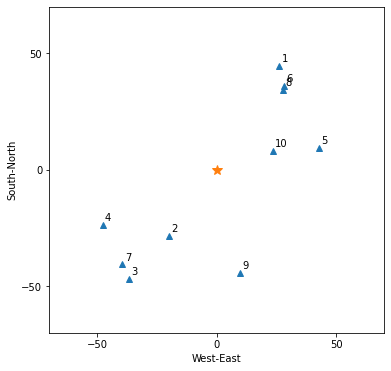

In [92]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(*stations_xy.T,marker='^',lw=0)
ax.plot([0],[0],marker='*',markersize=10)
for i in range(nstations):
    ax.text(stations_xy[i,0]+1,stations_xy[i,1]+1,"%i"%(i+1),verticalalignment='bottom',horizontalalignment='left')
ax.set_xlim(-70,70)
ax.set_ylim(-70,70)
ax.set_xticks([-50,0,50])
ax.set_yticks([-50,0,50])
ax.set_xlabel("West-East")
ax.set_ylabel("South-North")

In [93]:
receivers = pp.ListOfReceivers(*stations_xy.T,depth=3)

In [94]:
strike = 180
dip = 0
rake = 0
M0=1E7
depth = 15
moment_tensor = rtf2xyz(make_moment_tensor(strike, dip, rake, M0, 0, 0))
source = pp.PointSource(0,0,depth,moment_tensor,np.zeros([3,1]),0)

In [95]:
stf = lambda w: stf_trapezoidal(w, 3, 6)

In [96]:
nt = 80
delta_t = 0.5
time, seismograms = pp.compute_seismograms(model,source,receivers,nt,delta_t,source_time_function=stf)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 80.19it/s]


In [97]:
seismograms.shape

(10, 3, 80)

Text(0.5, 0, 'Time (s)')

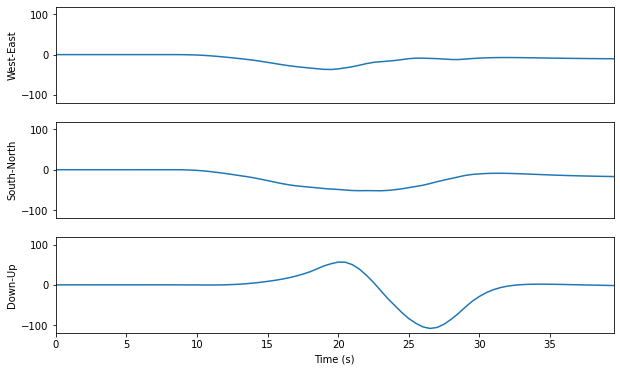

In [98]:
station_number = 1
irec = station_number - 1
fig,ax = plt.subplots(3,figsize=(10,6))
ax[0].plot(time,seismograms[irec,0,:])
ax[1].plot(time,seismograms[irec,1,:])
ax[2].plot(time,seismograms[irec,2,:])
[a.set_xticks([]) for a in ax[:-1]]
[a.set_xlim(0,(nt-1)*delta_t) for a in ax]
ylim = abs(seismograms[irec,:,:]).max()*1.1
[a.set_ylim(-ylim,ylim) for a in ax]
ax[0].set_ylabel("West-East")
ax[1].set_ylabel("South-North")
ax[2].set_ylabel("Down-Up")
ax[-1].set_xlabel("Time (s)")

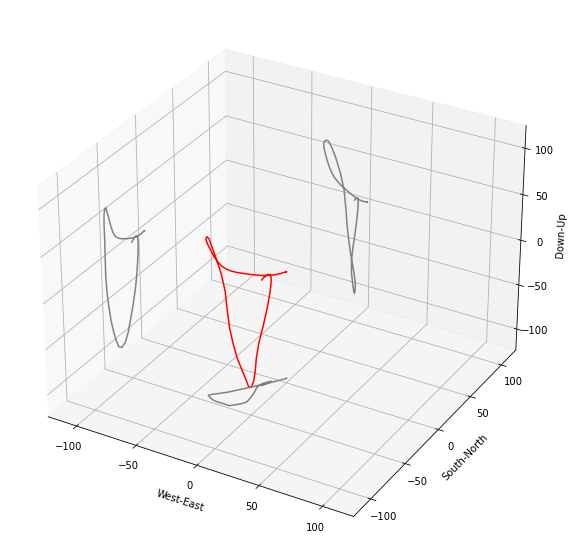

In [99]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot3D(seismograms[irec,0,:],seismograms[irec,1,:],seismograms[irec,2,:],color='red')
ax.set_xlim(-ylim,ylim)
ax.set_xlabel("West-East")
ax.plot3D(seismograms[irec,0,:],seismograms[irec,1,:],np.full(nt,-ylim),color='grey')
ax.set_ylim(-ylim,ylim)
ax.set_ylabel("South-North")
ax.plot3D(seismograms[irec,0,:],np.full(nt,ylim),seismograms[irec,2,:],color='grey')
ax.set_zlim(-ylim,ylim)
ax.set_zlabel("Down-Up")
ax.plot3D(np.full(nt,-ylim),seismograms[irec,1,:],seismograms[irec,2,:],color='grey')

In [100]:
receivers = pp.RegularlyDistributedReceivers(1,50,100,0,360,360,depth=3)
xx,yy = receivers.as_xy()

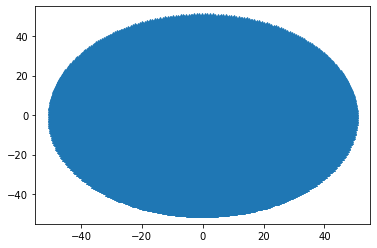

In [101]:
plt.plot(xx.flatten(),yy.flatten(),lw=0,marker='^')

In [102]:
static = pp.compute_static(model,source,receivers)

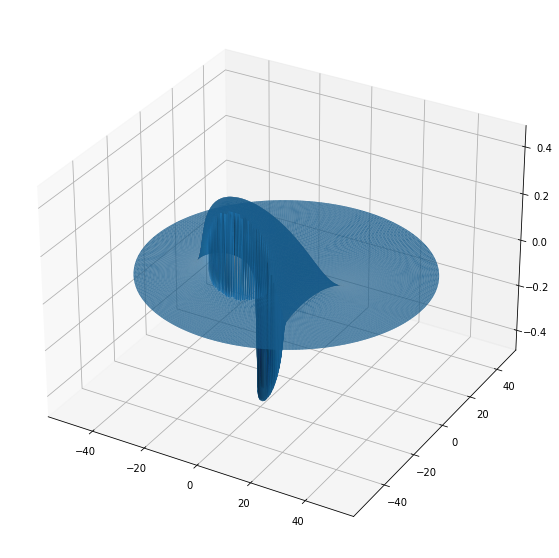

In [103]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
scale=0.1
scale2=0.001
ax.plot_trisurf((xx+scale*static[:,:,0]).flatten(),(yy+scale*static[:,:,1]).flatten(),scale2*static[:,:,2].flatten())

In [104]:
xx.shape

(100, 360)

In [105]:
static.shape

(100, 360, 3)

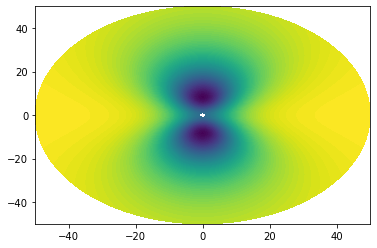

In [106]:
plt.contourf(xx,yy,static[:,:,1],100)

In [107]:
from matplotlib.tri import Triangulation, CubicTriInterpolator

In [108]:
rr = (xx**2+yy**2)**0.5

In [109]:
phph = np.arctan2(yy,xx)

In [110]:
tri = Triangulation(xx.flatten(),yy.flatten())

In [111]:
ffx = CubicTriInterpolator(tri,static[:,:,0].flatten())
ffy = CubicTriInterpolator(tri,static[:,:,1].flatten())
ffz = CubicTriInterpolator(tri,static[:,:,2].flatten())

In [112]:
gxx,gyy=np.meshgrid(np.linspace(-50,50,200),np.linspace(-50,50,200))

469.57581800109125


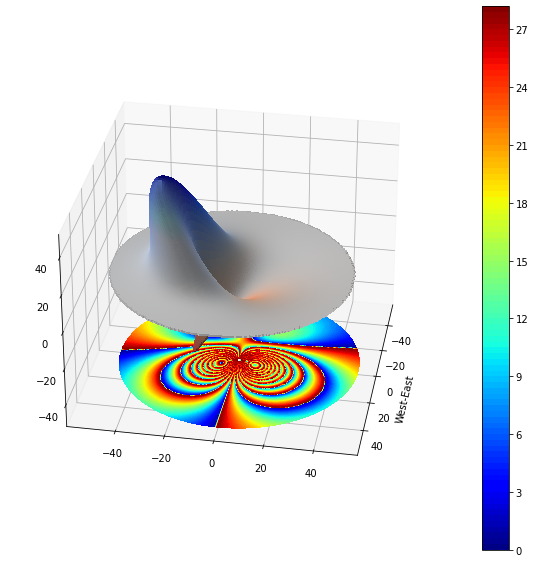

In [113]:
from matplotlib.colors import LightSource
view_azim=10
view_elev=30
%matplotlib inline
#%matplotlib osx
gzz=ffz(gxx,gyy)
ls = LightSource(90, 30)
cmax=abs(gzz).max()
print(cmax)
rgb = ls.shade(gzz, cmap=plt.cm.coolwarm_r,vmin=-cmax,vmax=cmax)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d',azim=view_azim,elev=view_elev)
scale_horiz=0.1
scale_vert = 0.1
zlim = 50 #1.1*abs(scale_vert*gzz).max()
surf = ax.plot_surface(gxx+scale_horiz*ffx(gxx,gyy),gyy+scale_horiz*ffy(gxx,gyy),scale_vert*gzz,facecolors=rgb,antialiased=False,rstride=1,cstride=1)
#ax.contour(gxx+scale_horiz*ffx(gxx,gyy),gyy+scale_horiz*ffy(gxx,gyy),scale_vert*gzz,80,colors='k')
#ax.plot_wireframe(gxx+scale_horiz*ffx(gxx,gyy),gyy+scale_horiz*ffy(gxx,gyy),scale_vert*gzz)

los_vector = np.array([np.cos(np.deg2rad(view_azim))*np.sin(np.deg2rad(90-view_elev)),
                       np.sin(np.deg2rad(view_azim))*np.sin(np.deg2rad(90-view_elev)),
                       np.cos(np.deg2rad(90-view_elev))])
static2 = pp.compute_static(model,source,receivers,los_vector=los_vector)


insar = ax.contourf(*receivers.as_xy(),static2%28,100,offset=-zlim,cmap=plt.cm.jet)
ax.set_xlabel("West-East")
ax.set_zlim(-zlim,zlim)
plt.colorbar(insar)



In [114]:
los_vector = np.array([np.cos(np.deg2rad(view_azim))*np.sin(np.deg2rad(90-view_elev)),
                       np.sin(np.deg2rad(view_azim))*np.sin(np.deg2rad(90-view_elev)),
                       np.cos(np.deg2rad(90-view_elev))])

In [115]:
los_vector

array([0.85286853, 0.15038373, 0.5       ])

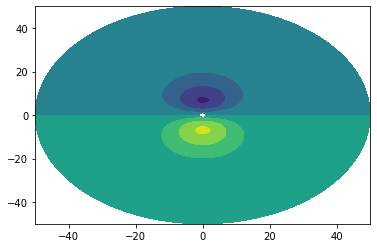

In [116]:
plt.contourf(*receivers.as_xy(),static[:,:,2])

In [29]:
static2 = pp.compute_static(model,source,receivers,los_vector=los_vector)

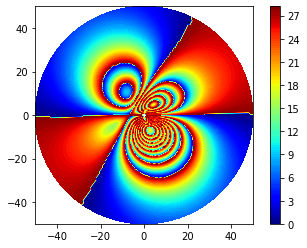

In [30]:
plt.contourf(*receivers.as_xy(),static2%28,100,cmap=plt.cm.jet)
plt.gca().set_aspect(1.)
plt.colorbar()

In [31]:
gzz.max()

271.31361886425685

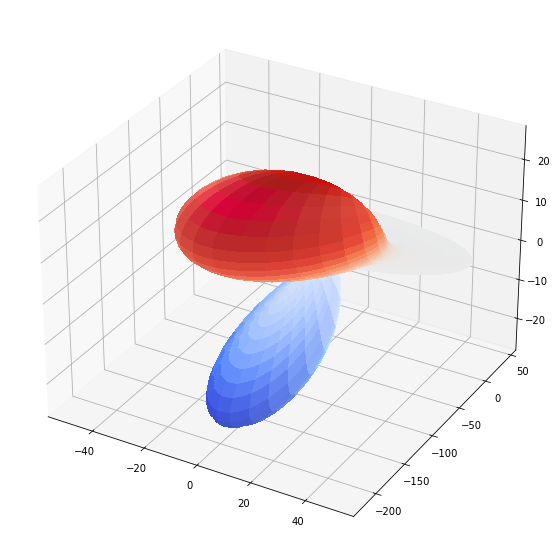

In [32]:
scale=0.2
scale2=0.1
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
from matplotlib.colors import LightSource
ls = LightSource(270, 45)
rgb = ls.shade(scale2*static[:,:,2], cmap=plt.cm.coolwarm)
ax.plot_surface(xx+scale*static[:,:,0],yy+scale+static[:,:,1],scale2*static[:,:,2],facecolors=rgb,antialiased=False,shade=False)
#ax.plot_trisurf((xx+scale*static[:,:,0]).flatten(),(yy+scale*static[:,:,1]).flatten(),scale2*static[:,:,0].flatten()
#                ,triangles=tri.triangles,cmap=plt.cm.gray,antialiased=False,facecolors=rgb)

In [33]:
rgb.shape

(100, 360, 4)

In [34]:
ls = LightSource(270,45)

In [35]:
rgb = ls.shade(static[:,:,2],plt.cm.copper)


In [36]:
Triangulation()

TypeError: Triangulation.__init__() missing 2 required positional arguments: 'x' and 'y'